# Rare and Unique Places in Toronto
## IBM Capstone Coursera Capstone Project

#### First, we install and import the required libraries

In [1]:
import requests 

import pandas as pd
import numpy as np

from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

from geopy.geocoders import Nominatim

import scipy.stats as stats

import urllib.request
from PIL import Image



In [2]:
pip install folium

     |████████████████████████████████| 93 kB 2.3 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import folium

### Creating the original dataframa
#### We get the URL and read it into a pandas dataframe, drop any 'not assigned' boroughs, and  ensure neighbourhoods in the same postal code are in the same row.

In [4]:
# Load the dataframe from Wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
df = pd.read_html(URL)
df = df[0]
# Drop any unassigned neighborhoods and join neighborhoods with the same postal code
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace = True)
df = df.groupby('Postal Code', sort = False).agg(lambda x: ','.join(x))
df.head()


,Borough,Neighbourhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Merging the dataframe with the geospatial data
#### We load the geospatial CSV file, merge it with the first dataframe, rearrange the columns, reset the index, then extract Toronto boroughs only

In [5]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
# geo_df = pd.read_csv('https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv')
df = df.merge(geo_df, left_index=True, right_on='Postal Code', how ='inner')
df = df[['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df_toronto=df[df['Borough'].str.contains("Toronto")]
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


#### Find the coordinates of Toronto

In [6]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="my_app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Define Foursquare Credentials (this is a hidden cell)

In [7]:
# @hidden_cell
# This cell is supposed to be hidden
CLIENT_ID = '23EQ42VMIHULYIIGQRT0WB5HLIQWU2ARS0VIPFDJRLK2DUTH' # your Foursquare ID
CLIENT_SECRET = 'P3MCMI0CV02QQ0BEX5GIQLP11355NGNQVWD0M30YOMNXRML1' # your Foursquare Secret
ACCESS_TOKEN = "FQW3BCWCDJW5VFLYAQKI3GWOGSCT52EGS5AZGWBGPZKEYVW4"
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Defining variables and functions for querying into Foursquare (these were taken from the IBM Capstone lab exercies).

In [11]:
neighbourhood_latitude = df_toronto.iloc[0]['Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_toronto.iloc[0]['Longitude'] # neighborhood longitude value

neighbourhood_name = df_toronto.iloc[0]['Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?\
&client_id={}\
&client_secret={}\
&v={}\
&ll={},{}\
&radius={}\
&limit={}'.format(
CLIENT_ID,
CLIENT_SECRET,
VERSION,
neighbourhood_latitude,
neighbourhood_longitude,
radius,
LIMIT)


Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


#### Request Foursquare for venues data, and defining functions for filtering the data

In [14]:
results = requests.get(url).json()

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name','venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


#### Define functions for getting nearby venues of a neighbourhood

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude',
                  'Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                  latitudes=df_toronto['Latitude'],
                                  longitudes=df_toronto['Longitude']
                                  )

In [20]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,53b8466a498e83df908c3f21,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,50760559e4b0e8c7babe2497,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant


#### Define functions to extract likes and list counts for each ID in toronto_venues:


In [21]:
def extract_likes(venue_id):
    likes_url = 'https://api.foursquare.com/v2/venues/{}/likes?\
    &client_id={}\
    &client_secret={}\
    &v={}'.format(venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)

    likes_results = requests.get(likes_url).json()
    return pd.json_normalize(likes_results)['response.likes.count'][0]

def extract_lists(venue_id):
    lists_url = 'https://api.foursquare.com/v2/venues/{}/listed?\
    &client_id={}\
    &client_secret={}\
    &v={}'.format(venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)

    lists_results = requests.get(lists_url).json()
    return pd.json_normalize(lists_results)['response.lists.count'][0]

In [22]:
toronto_venues['Likes'] = toronto_venues['Id'].apply(lambda venue_id: extract_likes(venue_id))
toronto_venues['Lists'] = toronto_venues['Id'].apply(lambda venue_id: extract_lists(venue_id))
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes,Lists
0,"Regent Park, Harbourfront",43.65426,-79.360636,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017,Bakery,48,133
1,"Regent Park, Harbourfront",43.65426,-79.360636,53b8466a498e83df908c3f21,Tandem Coffee,43.653559,-79.361809,Coffee Shop,49,70
2,"Regent Park, Harbourfront",43.65426,-79.360636,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center,18,0
3,"Regent Park, Harbourfront",43.65426,-79.360636,50760559e4b0e8c7babe2497,Body Blitz Spa East,43.654735,-79.359874,Spa,20,7
4,"Regent Park, Harbourfront",43.65426,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant,52,51


#### Find categories with lowest frequency

In [28]:
rare_categories = toronto_venues['Venue Category'].value_counts()==1
rare_categories = rare_categories[rare_categories]
rare_categories = rare_categories[rare_categories].index.tolist()
rare_categories


['College Cafeteria',
 'Airport Gate',
 'Molecular Gastronomy Restaurant',
 'German Restaurant',
 'Athletics & Sports',
 'Sake Bar',
 'Plane',
 'Hostel',
 'Coworking Space',
 'Harbor / Marina',
 'Recording Studio',
 'Strip Club',
 'Optical Shop',
 'Martial Arts School',
 'College Gym',
 'Frozen Yogurt Shop',
 'Organic Grocery',
 'Bus Line',
 'Hospital',
 'Garden Center',
 'Airport Food Court',
 'Skating Rink',
 'Church',
 'Taco Place',
 'Gas Station',
 'Hookah Bar',
 'Opera House',
 'Fruit & Vegetable Store',
 "Women's Store",
 'College Arts Building',
 'Other Great Outdoors',
 'Boutique',
 'Stadium',
 'College Rec Center',
 'College Auditorium',
 'Rental Car Location',
 'Theme Restaurant',
 'Kitchen Supply Store',
 'Southern / Soul Food Restaurant',
 'Bed & Breakfast',
 'Historic Site',
 'Filipino Restaurant',
 'Tanning Salon',
 'Boat or Ferry',
 'Swim School',
 'Taiwanese Restaurant',
 'Indoor Play Area',
 'Skate Park',
 'Intersection',
 'Airport Terminal',
 'Beach',
 'Climbing Gym',

#### Create a dataframe with only the rare venues, and find the top 10 unique venues

In [29]:
toronto_venues.rename(columns={'Venue Category': 'Venue_Category'}, inplace=True)
toronto_rare_venues=toronto_venues[toronto_venues.Venue_Category.isin(rare_categories)]
toronto_rare_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue_Category,Likes,Lists
7,"Regent Park, Harbourfront",43.654260,-79.360636,4ad4c05ef964a520bff620e3,The Distillery Historic District,43.650244,-79.359323,Historic Site,545,646
11,"Regent Park, Harbourfront",43.654260,-79.360636,4b0978e1f964a520cd1723e3,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop,180,160
69,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4ad4c062f964a520f9f720e3,Convocation Hall,43.660828,-79.395245,College Auditorium,19,5
73,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4de79e82887710a065bb44b0,Understudy Café at Gerstein,43.662308,-79.394098,College Cafeteria,0,0
94,"Garden District, Ryerson",43.657162,-79.378937,4bc1db6e2a89ef3beec8f288,Ryerson Athletics Centre,43.658434,-79.379296,College Rec Center,21,7
...,...,...,...,...,...,...,...,...,...,...
1597,Church and Wellesley,43.665860,-79.383160,4cccd8b3566aa093f46924fd,Flash,43.664319,-79.380190,Strip Club,17,8
1615,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,4c2dd403260bc928f78e1ad3,Ashbridges Bay Skatepark,43.662548,-79.315631,Skate Park,9,0
1616,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,4b12a1d8f964a5209a8b23e3,East End Garden Centre & Hardware,43.664564,-79.324471,Garden Center,4,0
1617,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,4e906caa9a52db7dba404ae5,Amin Car Repair Garage,43.663544,-79.320130,Auto Workshop,0,0


#### We discovered that there are 70 venues that have only one venue per category! Let's use this since this is already a large size. We will select those venues that only have the highest likes and among them.

In [30]:
top_10 = toronto_rare_venues.sort_values(by='Likes', ascending=False).head(10)
top_10

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue_Category,Likes,Lists
1269,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,4ad8df54f964a520881521e3,Billy Bishop Toronto City Airport (YTZ) (Billy...,43.631683,-79.396033,Airport,751,97
7,"Regent Park, Harbourfront",43.654260,-79.360636,4ad4c05ef964a520bff620e3,The Distillery Historic District,43.650244,-79.359323,Historic Site,545,646
550,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,4c05b0ce5753c92838e739f1,RS - Real Sports,43.642558,-79.379965,Sports Bar,531,227
11,"Regent Park, Harbourfront",43.654260,-79.360636,4b0978e1f964a520cd1723e3,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop,180,160
302,Berczy Park,43.644771,-79.373306,4c2e1fc7e116e21eb5bc8f60,Sugar Beach,43.643380,-79.367442,Beach,153,77
662,"Little Portugal, Trinity",43.647927,-79.419750,4e7dfa0fe5e871fe304ad004,The County General,43.644755,-79.416257,Southern / Soul Food Restaurant,124,244
1218,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,55820db4498e4abb523622bf,Otto's Berlin Döner,43.656387,-79.402788,Doner Restaurant,121,130
1240,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,4ddbe8697d8b771c0b09b885,Dim Sum King Seafood Restaurant,43.653503,-79.395405,Dim Sum Restaurant,96,42
1122,"University of Toronto, Harbord",43.662696,-79.400049,4ae8c418f964a52019b221e3,Athletic Centre,43.662487,-79.400657,College Gym,62,12
821,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,4ad4c062f964a520cff720e3,Lamport Stadium,43.638778,-79.423534,Stadium,57,6


#### Find Correlation between likes and lists count

In [37]:
r_value = round(stats.pearsonr(toronto_venues['Likes'],toronto_venues['Lists'])[0], 2)
print('The correlation coefficient is', r_value)

The correlation coefficient is 0.68


#### We can also extrapolate using linear regression

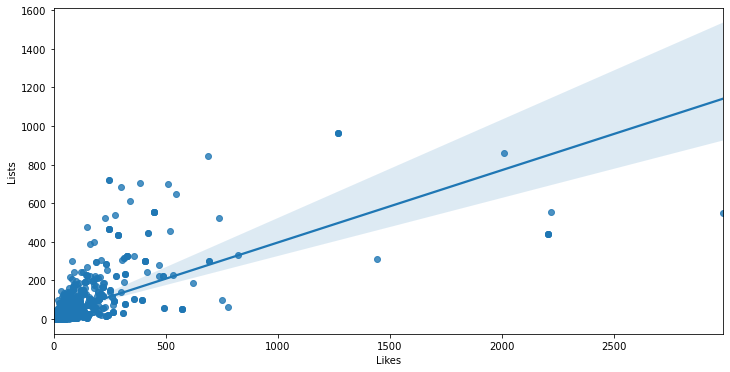

In [39]:
plt.figure(figsize=(12,6))
sns.regplot(toronto_venues['Likes'],toronto_venues['Lists'])

#### The result show a moderate correlation. For simplicity, we will just use the likes, and not use the lists count moving forward.

#### Now that we have determined that we will only use the likes, we will query Foursquare for these venues' photos and tips. We define the functions for these below

In [41]:
# Build a column for image URL:

LIMIT = 1

def extract_image(venue_id):
    image_url = 'https://api.foursquare.com/v2/venues/{}/photos?\
    &client_id={}\
    &client_secret={}\
    &v={}\
    &limit={}'.format(venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    LIMIT)

    image_url_results = requests.get(image_url).json()
    try:
        image_dict = pd.json_normalize(image_url_results)['response.photos.items'][0][0]
        image_dict = pd.json_normalize(image_url_results)['response.photos.items'][0][0]
        return image_dict['prefix']+'original'+image_dict['suffix']
    except:
        return None
    
    
    image_dict = pd.json_normalize(image_url_results)['response.photos.items'][0][0]
    return image_dict['prefix']+'original'+image_dict['suffix']

def extract_tip(venue_id):
    tip_url = 'https://api.foursquare.com/v2/venues/{}/tips?\
    &client_id={}\
    &client_secret={}\
    &v={}\
    &limit={}'.format(venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    LIMIT)

    tip_results = requests.get(tip_url).json()
    tips_dict = pd.json_normalize(tip_results)['response.tips.items'][0][0]   
    return tips_dict['text']

#### Add tip and venue id to the dataframe, then drop columns regarding coordinates since we won't need them anymore.

In [43]:
top_10['Image_url'] = top_10['Id'].apply(lambda venue_id: extract_image(venue_id))
top_10['Tip'] = top_10['Id'].apply(lambda venue_id: extract_tip(venue_id))

top_10 = top_10.reset_index()
top_10.drop(['index','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Longitude', 'Venue Latitude'], axis=1, inplace=True)
top_10

,Neighbourhood,Id,Venue,Venue_Category,Likes,Lists,Image_url,Tip
0,"CN Tower, King and Spadina, Railway Lands, Har...",4ad8df54f964a520881521e3,Billy Bishop Toronto City Airport (YTZ) (Billy...,Airport,751,97,https://fastly.4sqi.net/img/general/original/3...,My favourite airport. Tiny but with a very ni...
1,"Regent Park, Harbourfront",4ad4c05ef964a520bff620e3,The Distillery Historic District,Historic Site,545,646,https://fastly.4sqi.net/img/general/original/1...,North America's largest and most well preserve...
2,"Harbourfront East, Union Station, Toronto Islands",4c05b0ce5753c92838e739f1,RS - Real Sports,Sports Bar,531,227,https://fastly.4sqi.net/img/general/original/3...,Have been coming here for about 5yrs. Beer is ...
3,"Regent Park, Harbourfront",4b0978e1f964a520cd1723e3,SOMA chocolatemaker,Chocolate Shop,180,160,https://fastly.4sqi.net/img/general/original/e...,International Award Winning Chocolate maker. I...
4,Berczy Park,4c2e1fc7e116e21eb5bc8f60,Sugar Beach,Beach,153,77,https://fastly.4sqi.net/img/general/original/6...,Relaxing location not far from distillery. Lot...
5,"Little Portugal, Trinity",4e7dfa0fe5e871fe304ad004,The County General,Southern / Soul Food Restaurant,124,244,https://fastly.4sqi.net/img/general/original/4...,"The staple in my dining adventures, I've eaten..."
6,"Kensington Market, Chinatown, Grange Park",55820db4498e4abb523622bf,Otto's Berlin Döner,Doner Restaurant,121,130,https://fastly.4sqi.net/img/general/original/1...,What a place to grab a quick meal! Great locat...
7,"Kensington Market, Chinatown, Grange Park",4ddbe8697d8b771c0b09b885,Dim Sum King Seafood Restaurant,Dim Sum Restaurant,96,42,https://fastly.4sqi.net/img/general/original/0...,"Great place for dim sum in Chinatown, everythi..."
8,"University of Toronto, Harbord",4ae8c418f964a52019b221e3,Athletic Centre,College Gym,62,12,None,Busiest weight room times: Mon-Fri 5:30pm-7:30...
9,"Brockton, Parkdale Village, Exhibition Place",4ad4c062f964a520cff720e3,Lamport Stadium,Stadium,57,6,https://fastly.4sqi.net/img/general/original/3...,This venue is a short walk from Exhibition Sta...


#### now have our final dataset! For clarity, below is the summary of our top 10 venues.

In [44]:
print('The most popular venue among the most unique venues is {} with {} number of likes'.format(top_10[top_10['Likes']==top_10['Likes'].max()]['Venue'][0], top_10['Likes'].max()))
print('The least popular venue among the most unique venues is {} with {} number of likes'.format(top_10[top_10['Likes']==top_10['Likes'].min()]['Venue'][len(top_10)-1], top_10['Likes'].min()))


The most popular venue among the most unique venues is Billy Bishop Toronto City Airport (YTZ) (Billy Bishop Toronto City Airport) with 751 number of likes
The least popular venue among the most unique venues is Lamport Stadium with 57 number of likes


In [45]:
top_10[['Venue', 'Venue_Category','Likes']]

,Venue,Venue_Category,Likes
0,Billy Bishop Toronto City Airport (YTZ) (Billy...,Airport,751
1,The Distillery Historic District,Historic Site,545
2,RS - Real Sports,Sports Bar,531
3,SOMA chocolatemaker,Chocolate Shop,180
4,Sugar Beach,Beach,153
5,The County General,Southern / Soul Food Restaurant,124
6,Otto's Berlin Döner,Doner Restaurant,121
7,Dim Sum King Seafood Restaurant,Dim Sum Restaurant,96
8,Athletic Centre,College Gym,62
9,Lamport Stadium,Stadium,57


#### And below, we display each venue, along with their photo and tip.

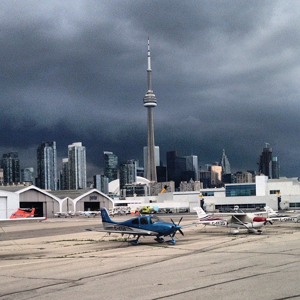

Venue # 1
Venue Name:  Billy Bishop Toronto City Airport (YTZ) (Billy Bishop Toronto City Airport)
Category:  Airport
Tip:  My favourite airport.  Tiny but with a very nice lounge (Porter airlines).  Service back and forth to mainland via ferryboat (and bus to Union Station)..  The view as you fly in/land is amazing.




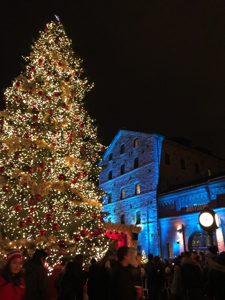

Venue # 2
Venue Name:  The Distillery Historic District
Category:  Historic Site
Tip:  North America's largest and most well preserved collection of Victorian industrial architecture is also brimming with creativity; the pedestrian only village is home to over 20 art studios & galleries




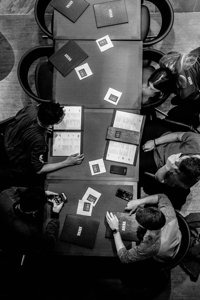

Venue # 3
Venue Name:  RS - Real Sports
Category:  Sports Bar
Tip:  Have been coming here for about 5yrs. Beer is mostly corporate, but they do support locals, with some guest taps too. 30+ kinds of beer. Superb atmosphere, amazing sports venue. Pizza nachos are GREAT




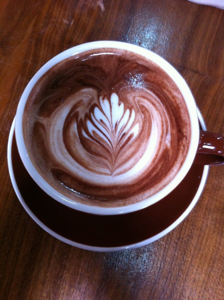

Venue # 4
Venue Name:  SOMA chocolatemaker
Category:  Chocolate Shop
Tip:  International Award Winning Chocolate maker. I adore the Balsamic Vinegar truffle and the Pop Rocks Truffle is too fun. Their gelato is full of great Ontario flavours.




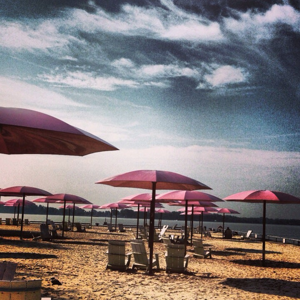

Venue # 5
Venue Name:  Sugar Beach
Category:  Beach
Tip:  Relaxing location not far from distillery. Lots of chairs and umbrellas to sit and enjoy the lake views




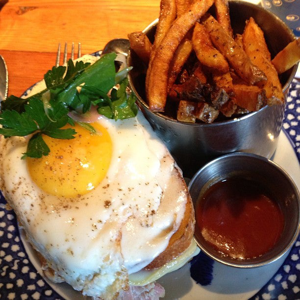

Venue # 6
Venue Name:  The County General
Category:  Southern / Soul Food Restaurant
Tip:  The staple in my dining adventures, I've eaten at the County 1-2 times per week for the last two years. The cocktails are magnificent. Come with a friend and get one of the 'for two' dishes.




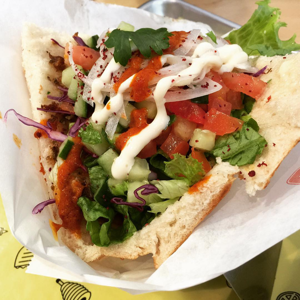

Venue # 7
Venue Name:  Otto's Berlin Döner
Category:  Doner Restaurant
Tip:  What a place to grab a quick meal! Great location plus it has a vibe. The food is tasty and beers are excelent. Read the full review: http://torontoism.com/toronto-restaurant-reviews/otto-berlin-doner




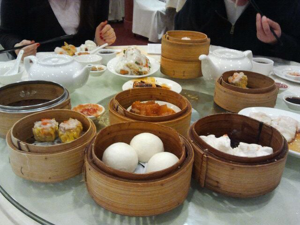

Venue # 8
Venue Name:  Dim Sum King Seafood Restaurant
Category:  Dim Sum Restaurant
Tip:  Great place for dim sum in Chinatown, everything tasted fresh though the spring rolls had a strange after taste. Not bad, just strange. Many food options, traditional wheel carts for bringing the food


NO IMAGE FOUND!
Venue # 9
Venue Name:  Athletic Centre
Category:  College Gym
Tip:  Busiest weight room times: Mon-Fri 5:30pm-7:30pm, sat-Sun 3:30pm-5:00pm. Note: weight room has women's only hours Tues & Fri 5pm-6pm




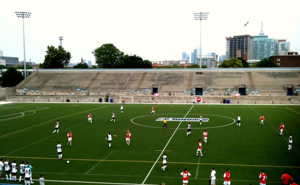

Venue # 10
Venue Name:  Lamport Stadium
Category:  Stadium
Tip:  This venue is a short walk from Exhibition Station GO Rail, and a short walk from the King West and Lakeshore/Exhibition streetcar routes. It is also served by the 63 Ossington bus.




In [46]:
for i in range(len(top_10)):
    try:
        img = Image.open(urllib.request.urlopen(top_10.iloc[i]['Image_url']))
        img.thumbnail((300,300))
        display(img)
    except:
        print('NO IMAGE FOUND!')
#     display(Image.open(urllib.request.urlopen(top_10.iloc[i]['Image_url'])))
    print ('Venue #',i+1)
    print('Venue Name: ', top_10.iloc[i]['Venue'])
    print('Category: ', top_10.iloc[i]['Venue_Category'])
    print('Tip: ', top_10.iloc[i]['Tip'])
    print('\n')

#### This concludes this Capstone Project. Thank you for reading!
 
  
The formal report can be found here: https://github.com/josh-arrabaca/Coursera_Capstone/blob/main/IBM-Capstone-Final-Report.md

And the presentation can be found here: https://github.com/josh-arrabaca/Coursera_Capstone/blob/main/Rare%20Places%20in%20Toronto.pdf